# BYOL CIFAR10 Tutorial Ai Summer

## Basic imports

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

def reproducibility(SEED):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)

def define_param_groups(model, weight_decay, optimizer_name):
    def exclude_from_wd_and_adaptation(name):
        if 'bn' in name:
            return True
        if optimizer_name == 'lars' and 'bias' in name:
            return True

    param_groups = [
        {
            'params': [p for name, p in model.named_parameters() if not exclude_from_wd_and_adaptation(name)],
            'weight_decay': weight_decay,
            'layer_adaptation': True,
        },
        {
            'params': [p for name, p in model.named_parameters() if exclude_from_wd_and_adaptation(name)],
            'weight_decay': 0.,
            'layer_adaptation': False,
        },
    ]
    return param_groups

## Augmentations 


In [ ]:
import torch
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import random


class Augment:
    """
    A stochastic data augmentation module
    Transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """
    def __init__(self, img_size, s=1):
        color_jitter = T.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        blur = T.GaussianBlur((3, 3), (0.1, 2.0))

        self.train_transform = T.Compose([
            T.ToTensor(),
            T.RandomResizedCrop(size=img_size),
            T.RandomHorizontalFlip(p=0.5),  # with 0.5 probability
            T.RandomApply([color_jitter], p=0.8),
            T.RandomApply([blur], p=0.5),
            T.RandomGrayscale(p=0.2),
            # imagenet stats
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])            
        ])
    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x), 

# Dataloaders

In [ ]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

def get_cifar10_dataloader(batch_size, train=True, transform=Augment(224)):
    dataset = CIFAR10(root="./", train=train, transform=transform, download=True)
    return DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4, drop_last=True)
data_transform = Augment(32)
dataloader = get_cifar10_dataloader(batch_size=64, train=True, transform=data_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


# BYOL method

In [ ]:
import copy
import torch
from torch import nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, dim, embedding_size=256, hidden_size=2048, batch_norm_mlp=False):
        super().__init__()
        norm = nn.BatchNorm1d(hidden_size) if batch_norm_mlp else nn.Identity()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            norm,
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, embedding_size)
        )

    def forward(self, x):
        return self.net(x)


class AddProjHead(nn.Module):
    def __init__(self, model, in_features, layer_name, hidden_size=4096,
                 embedding_size=256, batch_norm_mlp=True):
        super(AddProjHead, self).__init__()
        self.backbone = model
        # remove last layer 'fc' or 'classifier'
        setattr(self.backbone, layer_name, nn.Identity())
        self.backbone.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.maxpool = torch.nn.Identity()
        # add mlp projection head
        self.projection = MLP(in_features, embedding_size, hidden_size=hidden_size, batch_norm_mlp=batch_norm_mlp)

    def forward(self, x, return_embedding=False):
        embedding = self.backbone(x)
        if return_embedding:
            return embedding
        return self.projection(embedding)


def loss_fn(x, y):
    # L2 normalization
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)


class EMA():
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.alpha + (1 - self.alpha) * new



class BYOL(nn.Module):
    def __init__(
            self,
            net,
            batch_norm_mlp=True,
            layer_name='fc',
            in_features=512,
            projection_size=256,
            projection_hidden_size=2048,
            moving_average_decay=0.99,
            use_momentum=True):
        """
        Args:
            net: model to be trained
            batch_norm_mlp: whether to use batchnorm1d in the mlp predictor and projector
            in_features: the number features that are produced by the backbone net i.e. resnet
            projection_size: the size of the output vector of the two identical MLPs
            projection_hidden_size: the size of the hidden vector of the two identical MLPs
            augment_fn2: apply different augmentation the second view
            moving_average_decay: t hyperparameter to control the influence in the target network weight update
            use_momentum: whether to update the target network
        """
        super().__init__()
        self.net = net
        self.student_model = AddProjHead(model=net, in_features=in_features,
                                         layer_name=layer_name,
                                         embedding_size=projection_size,
                                         hidden_size=projection_hidden_size,
                                         batch_norm_mlp=batch_norm_mlp)
        self.use_momentum = use_momentum
        self.teacher_model = self._get_teacher()
        self.target_ema_updater = EMA(moving_average_decay)
        self.student_predictor = MLP(projection_size, projection_size, projection_hidden_size)
    
    @torch.no_grad()
    def _get_teacher(self):
        return copy.deepcopy(self.student_model)
    
    @torch.no_grad()
    def update_moving_average(self):
        assert self.use_momentum, 'you do not need to update the moving average, since you have turned off momentum ' \
                                  'for the target encoder '
        assert self.teacher_model is not None, 'target encoder has not been created yet'

        for student_params, teacher_params in zip(self.student_model.parameters(), self.teacher_model.parameters()):
          old_weight, up_weight = teacher_params.data, student_params.data
          teacher_params.data = self.target_ema_updater.update_average(old_weight, up_weight)

    def forward(
            self,
            image_one, image_two=None,
            return_embedding=False):
        if return_embedding or (image_two is None):
            return self.student_model(image_one, return_embedding=True)

        # student projections: backbone + MLP projection
        student_proj_one = self.student_model(image_one)
        student_proj_two = self.student_model(image_two)

        # additional student's MLP head called predictor
        student_pred_one = self.student_predictor(student_proj_one)
        student_pred_two = self.student_predictor(student_proj_two)

        with torch.no_grad():
            # teacher processes the images and makes projections: backbone + MLP
            teacher_proj_one = self.teacher_model(image_one).detach_()
            teacher_proj_two = self.teacher_model(image_two).detach_()
            
        loss_one = loss_fn(student_pred_one, teacher_proj_one)
        loss_two = loss_fn(student_pred_two, teacher_proj_two)        

        return (loss_one + loss_two).mean()


# LARS optimizer


In [ ]:
from torch.optim.optimizer import Optimizer, required
import torch

# almost copy paste from https://github.com/noahgolmant/pytorch-lars/blob/master/lars.py
class LARS(Optimizer):
    r"""Implements LARS (Layer-wise Adaptive Rate Scaling).
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        eta (float, optional): LARS coefficient as used in the paper (default: 1e-3)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
        epsilon (float, optional): epsilon to prevent zero division (default: 0)
    Example:
        >>> optimizer = torch.optim.LARS(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=required, momentum=0, eta=1e-3, dampening=0,
                 weight_decay=0, nesterov=False, epsilon=0):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, eta=eta, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov, epsilon=epsilon)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(LARS, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(LARS, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            eta = group['eta']
            dampening = group['dampening']
            nesterov = group['nesterov']
            epsilon = group['epsilon']

            for p in group['params']:
                if p.grad is None:
                    continue
                w_norm = torch.norm(p.data)
                g_norm = torch.norm(p.grad.data)
                if w_norm * g_norm > 0:
                    local_lr = eta * w_norm / (g_norm +
                        weight_decay * w_norm + epsilon)
                else:
                    local_lr = 1
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(p.data, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                    buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(d_p, alpha=-local_lr * group['lr'])

        return loss

# Pre-train function

In [ ]:
def training_step(model, data):
    (view1, view2), _ = data
    loss = model(view1.cuda(), view2.cuda())
    return loss

def train_one_epoch(model, train_dataloader, optimizer):
    model.train()
    total_loss = 0.
    num_batches = len(train_dataloader)
    for data in train_dataloader:
        optimizer.zero_grad()
        loss = training_step(model, data)
        loss.backward()
        optimizer.step()
        # EMA update
        model.update_moving_average()

        total_loss += loss.item()
        
    
    return total_loss/num_batches

# KNN evaluation to track classification accuray through ssl pretraining

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from torch import nn


class KNN():
    def __init__(self, model, k, device):
        super(KNN, self).__init__()
        self.k = k
        self.device = device
        self.model = model.to(device)
        self.model.eval()

    def extract_features(self, loader):
        """
        Infer/Extract features from a trained model
        Args:
            loader: train or test loader
        Returns: 3 tensors of all:  input_images, features , labels
        """
        x_lst = []
        features = []
        label_lst = []

        with torch.no_grad():
            for input_tensor, label in loader:
                h = self.model(input_tensor.to(self.device))
                features.append(h)
                x_lst.append(input_tensor)
                label_lst.append(label)

            x_total = torch.stack(x_lst)
            h_total = torch.stack(features)
            label_total = torch.stack(label_lst)

            return x_total, h_total, label_total

    def knn(self, features, labels, k=1):
        """
        Evaluating knn accuracy in feature space.
        Calculates only top-1 accuracy (returns 0 for top-5)
        Args:
            features: [... , dataset_size, feat_dim]
            labels: [... , dataset_size]
            k: nearest neighbours
        Returns: train accuracy, or train and test acc
        """
        feature_dim = features.shape[-1]
        with torch.no_grad():
            features_np = features.cpu().view(-1, feature_dim).numpy()
            labels_np = labels.cpu().view(-1).numpy()
            # fit
            self.cls = KNeighborsClassifier(k, metric="cosine").fit(features_np, labels_np)
            acc = self.eval(features, labels)
            
        return acc
    
    def eval(self, features, labels):
      feature_dim = features.shape[-1]
      features = features.cpu().view(-1, feature_dim).numpy()
      labels = labels.cpu().view(-1).numpy()
      acc = 100 * np.mean(cross_val_score(self.cls, features, labels))
      return acc

    def _find_best_indices(self, h_query, h_ref):
        h_query = h_query / h_query.norm(dim=1).view(-1, 1)
        h_ref = h_ref / h_ref.norm(dim=1).view(-1, 1)
        scores = torch.matmul(h_query, h_ref.t())  # [query_bs, ref_bs]
        score, indices = scores.topk(1, dim=1)  # select top k best
        return score, indices

    def fit(self, train_loader, test_loader=None):
        with torch.no_grad():
            x_train, h_train, l_train = self.extract_features(train_loader)
            train_acc = self.knn(h_train, l_train, k=self.k)

            if test_loader is not None:
                x_test, h_test, l_test = self.extract_features(test_loader)
                test_acc = self.eval(h_test, l_test)
                return train_acc, test_acc

# Putting it all together

In [ ]:
import torchvision.models as models
import torch
import numpy as np
import os
import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from google.colab import files

load = False
model = models.resnet18(pretrained=False)
model = BYOL(model, in_features=512, batch_norm_mlp=True)
model.cuda()

# optimizer and loss
lr = 3e-4
weight_decay = 0.000001
BATCH_SIZE  = 256


#param_groups = define_param_groups(model, weight_decay, 'lars')    
#optimizer = LARS(param_groups, lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# data
data_transform = Augment(32)

test_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])


loader_train = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=True, transform=data_transform)
loader_train_plain = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=True, transform=test_transform)
loader_test = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=False, transform=test_transform)


# general info
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
print('available_gpus:',available_gpus)

PATH = 'BYOL_resNet18.ckpt'

reproducibility(9999)

if load:
  model.load_state_dict(torch.load("....ckpt"))


epochs = 100
mean_losses = []
train_knns = []
val_knns = []

for i in range(epochs):
  mean_loss = train_one_epoch(model, loader_train, optimizer)
  
  mean_losses.append(mean_loss)
  if (i%4)==0:
    # KNN evaluation
    ssl_evaluator = KNN(model=model, k=1, device='cuda')
    train_acc, val_acc = ssl_evaluator.fit(loader_train_plain, loader_test)
    print(f'\n Epoch {i}: loss:{mean_loss}')
    print(f"k-nn accuracy k= {ssl_evaluator.k} for train split: {train_acc}")
    print(f"k-nn accuracy k= {ssl_evaluator.k} for val split: {val_acc} \n")
    print('-----------------')
    train_knns.append(train_acc)
    val_knns.append(val_acc)


import matplotlib.pyplot as plt

plt.plot(train_knns, label='train set KNN acc (%)')
plt.plot(val_knns, label='val set KNN acc (%)')
plt.ylabel('Accuracy in %')
plt.xlabel('Epochs')
plt.legend()


torch.save(model.state_dict(), PATH)
files.download(PATH)

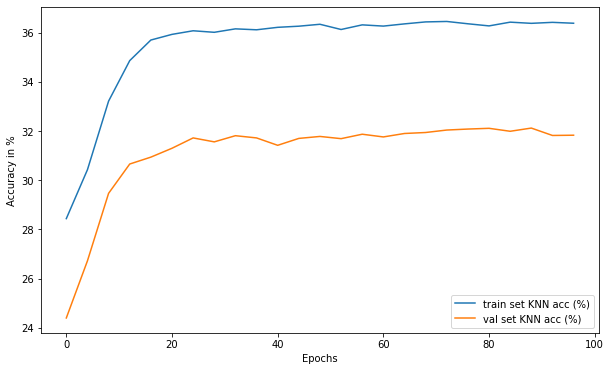

In [ ]:
indices = range(0,100,4)
plt.figure(figsize=(10,6))
plt.plot(indices, train_knns, label='train set KNN acc (%)')
plt.plot(indices, val_knns, label='val set KNN acc (%)')
plt.ylabel('Accuracy in %')
plt.xlabel('Epochs')
plt.legend()

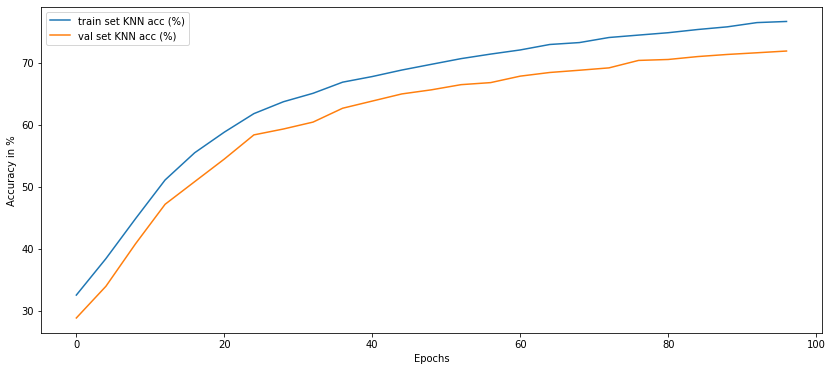

In [ ]:
indices = range(0,100,4)
plt.figure(figsize=(14,6))
plt.plot(indices, train_knns, label='train set KNN acc (%)')
plt.plot(indices, val_knns, label='val set KNN acc (%)')
plt.ylabel('Accuracy in %')
plt.xlabel('Epochs')
plt.legend()

# Fine-tune

In [ ]:
import torchvision
PATH = 'BYOL_resNet18.ckpt'

import torch.optim as optim
import torchvision

def train(model, trainloader, epochs, device, valloader, criterion):
  optimizer = optim.SGD(model.parameters(), lr=0.0008, momentum=0.9)
  model.to(device)
  epoch_loss = []
  val_accs = []
  train_accs = []
  # loop over the dataset multiple times
  for epoch in range(epochs):  
      running_loss = 0.0
      correct = 0
      total = 0
      model.train()
      for i, data in enumerate(trainloader):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device) , data[1].to(device)
          labels = labels.view(-1)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # track statistics
          with torch.no_grad():
            running_loss += loss.item()
            correct += calc_correct(outputs,labels)
            total += labels.size(0)

      print(f"\n Epoch [{epoch + 1} / {epochs}] Loss: {running_loss/len(trainloader)}")
      epoch_loss.append(running_loss)
      running_loss = 0.0
      train_acc = (100 * correct / total)
      val_acc = val(model,device,valloader)
      print(f'Train VS Val Accuracy: {train_acc} VS {val_acc}')
      val_accs.append(val_acc)
      train_accs.append(train_acc)
  
  print('Finished Training')
  
  return model,epoch_loss,val_accs,train_accs

def val(model, device, valloader):
  correct = 0
  total = 0
  model.eval()
  model.to(device)
  with torch.no_grad():
      for data in valloader:
          images, labels = data[0].to(device) , data[1].to(device)
          labels = labels.view(-1)
          # calculate outputs by running images through the network
          outputs = model(images)
          correct += calc_correct(outputs,labels)
          total += labels.size(0)
          
  acc =  (100 * correct / total)
  return acc

def calc_correct(outputs,labels):
  _, predicted = torch.max(outputs.data, 1)
  
  return (predicted == labels).sum().item() 

def define_augmentation(image_size):
  DEFAULT_AUG =  T.Compose([
        T.ToTensor(),                    
        T.RandomHorizontalFlip(p=0.1),
        T.RandomVerticalFlip(p=0.1),
        T.RandomResizedCrop((image_size, image_size),scale=(0.5, 1.0)),
       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
  ])
  return DEFAULT_AUG

def main(mode='byol'):
    reproducibility(77777)   
    device = 'cuda'
    data_transform = Augment(32)
    BATCH_SIZE = 256

    test_transform = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

    train_loader = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=True, transform=define_augmentation(32))
    test_loader = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=False, transform=test_transform)

    if mode == 'random':
      model = torchvision.models.resnet18(pretrained=False)
      model.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10))
    elif mode == 'byol':
      model = models.resnet18(pretrained=False)
      model_ssl = BYOL(model, in_features=512, batch_norm_mlp=True)

      model_ssl.load_state_dict(torch.load(PATH))
      model = model_ssl.student_model.backbone
      model.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10))
    else:
      model = torchvision.models.resnet18(pretrained=True)
      model.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10))
    
    criterion = torch.nn.CrossEntropyLoss()

    model, epoch_loss, val_accs, train_accs = train(model, train_loader,
                                                      epochs=20, device=device, 
                                                      valloader=test_loader,
                                                    criterion=criterion)
    return model,val_accs

###########################################################################

model_byol, val_accs_1 = main('byol')
_, val_accs_2 = main('imagenet')

import matplotlib.pyplot as plt

plt.plot(val_accs_1, label='byol')
plt.plot(val_accs_2, label='supervised-imagenet-pretrained-weights')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.plot(val_accs_1, label='byol-simpleCNN')
plt.plot(val_accs_2, label='supervised-imagenet-resnet18')
plt.plot(val_accs_3, label='random-weights-simpleCNN')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()